In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv("QVI_data.csv")

In [3]:
df.head(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


# Find the monthly sales for all the shops

In [5]:
# Ensure DATE is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')  # Convert, coercing invalid values to NaT

In [6]:
df['YEAR_MONTH'] = df['DATE'].dt.to_period('M')  # 'M' denotes month

In [7]:
# Group by store number and year-month, then sum the total sales
monthly_sales = df.groupby(['STORE_NBR', 'YEAR_MONTH'])['TOT_SALES'].sum().reset_index()

In [8]:
print(monthly_sales)

      STORE_NBR YEAR_MONTH  TOT_SALES
0             1    2018-07      206.9
1             1    2018-08      176.1
2             1    2018-09      278.8
3             1    2018-10      188.1
4             1    2018-11      192.6
...         ...        ...        ...
3164        272    2019-02      395.5
3165        272    2019-03      442.3
3166        272    2019-04      445.1
3167        272    2019-05      314.6
3168        272    2019-06      312.1

[3169 rows x 3 columns]


# Find the monthly number of customers 

In [9]:
# Group by store number and year-month, then count the unique loyalty card numbers
monthly_customers = df.groupby(['STORE_NBR', 'YEAR_MONTH'])['LYLTY_CARD_NBR'].nunique().reset_index()

In [10]:
# Rename the column to 'NUM_CUSTOMERS' for clarity
monthly_customers.rename(columns={'LYLTY_CARD_NBR': 'NUM_CUSTOMERS'}, inplace=True)

In [11]:
# Display the result
print(monthly_customers)

      STORE_NBR YEAR_MONTH  NUM_CUSTOMERS
0             1    2018-07             49
1             1    2018-08             42
2             1    2018-09             59
3             1    2018-10             44
4             1    2018-11             46
...         ...        ...            ...
3164        272    2019-02             45
3165        272    2019-03             50
3166        272    2019-04             54
3167        272    2019-05             34
3168        272    2019-06             34

[3169 rows x 3 columns]


# Find the Monthly number of transactions per customer

In [12]:
# Group by loyalty card number and year-month, then count the number of transactions per customer
monthly_transactions_per_customer = df.groupby(['LYLTY_CARD_NBR', 'YEAR_MONTH'])['TXN_ID'].nunique().reset_index()

In [13]:
# Rename the column to 'NUM_TRANSACTIONS' for clarity
monthly_transactions_per_customer.rename(columns={'TXN_ID': 'NUM_TRANSACTIONS'}, inplace=True)

In [14]:
# Display the result
print(monthly_transactions_per_customer)

        LYLTY_CARD_NBR YEAR_MONTH  NUM_TRANSACTIONS
0                 1000    2018-10                 1
1                 1002    2018-09                 1
2                 1003    2019-03                 2
3                 1004    2018-11                 1
4                 1005    2018-12                 1
...                ...        ...               ...
221274         2370651    2018-08                 1
221275         2370701    2018-12                 1
221276         2370751    2018-10                 1
221277         2370961    2018-10                 2
221278         2373711    2018-12                 1

[221279 rows x 3 columns]


# Closest Stores based on the sales

In [15]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

In [16]:
# Step 2: Pivot the data to have stores as columns and months as rows
monthly_sales_pivot = monthly_sales.pivot(index='YEAR_MONTH', columns='STORE_NBR', values='TOT_SALES').fillna(0)

In [17]:
def find_closest_stores(target_store, store_pivot, n_closest=3):
    target_sales = store_pivot[target_store].values.reshape(1, -1)  # Target store sales data
    other_stores = store_pivot.drop(columns=[target_store])  # Drop target store data
    
    # Compute Euclidean distances between the target store and other stores
    distances = euclidean_distances(target_sales, other_stores.T)  # Transpose to compare target to other stores
    
    # Get the indices of the closest stores
    closest_stores_idx = np.argsort(distances[0])[:n_closest]
    
    # Get the store numbers for the closest stores
    closest_stores = other_stores.columns[closest_stores_idx].tolist()
    
    return closest_stores

In [18]:
# Step 4: Find 3 closest stores for stores 77, 86, and 88
closest_stores_77 = find_closest_stores(77, monthly_sales_pivot)
closest_stores_86 = find_closest_stores(86, monthly_sales_pivot)
closest_stores_88 = find_closest_stores(88, monthly_sales_pivot)

In [19]:
# Display the results
print(f"3 closest stores to store 77: {closest_stores_77}")
print(f"3 closest stores to store 86: {closest_stores_86}")
print(f"3 closest stores to store 88: {closest_stores_88}")

3 closest stores to store 77: [46, 185, 188]
3 closest stores to store 86: [229, 109, 155]
3 closest stores to store 88: [40, 165, 237]


# Find how many bags of chips each customer has bought per month

In [20]:
#Group by customer and month, summing the total quantity bought
monthly_purchase_per_customer = df.groupby(['LYLTY_CARD_NBR', 'YEAR_MONTH'])['PROD_QTY'].sum().reset_index()

In [21]:
print(monthly_purchase_per_customer)

        LYLTY_CARD_NBR YEAR_MONTH  PROD_QTY
0                 1000    2018-10         2
1                 1002    2018-09         1
2                 1003    2019-03         2
3                 1004    2018-11         1
4                 1005    2018-12         1
...                ...        ...       ...
221274         2370651    2018-08         2
221275         2370701    2018-12         2
221276         2370751    2018-10         2
221277         2370961    2018-10         4
221278         2373711    2018-12         2

[221279 rows x 3 columns]


# Find how the similar performing(control stores) are performing against the trail stores where there is an experiment

In [22]:
# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

In [23]:
# Filter data for the period July 2018 to June 2019
start_date = '2018-07-01'
end_date = '2019-06-30'
filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

In [24]:
# Define the closest stores for each store
closest_stores = {
    77: [46, 185, 188],
    86: [229, 109, 155],
    88: [40, 165, 237]
}

In [25]:
# Flatten the list of all relevant stores
stores_of_interest = [77, 86, 88] + [store for sublist in closest_stores.values() for store in sublist]

In [26]:
# Filter the dataset to include only the relevant stores
filtered_stores_df = filtered_df[filtered_df['STORE_NBR'].isin(stores_of_interest)]

In [27]:
# View the filtered data
print(filtered_stores_df.head())

       LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
35347           40000 2018-10-07         40   36107        81   
35348           40000 2019-01-20         40   36108        28   
35349           40000 2019-06-30         40   36109        32   
35350           40001 2019-06-30         40   36110        25   
35351           40002 2018-09-24         40   36111       108   

                                      PROD_NAME  PROD_QTY  TOT_SALES  \
35347           Pringles Original   Crisps 134g         2        7.4   
35348      Thins Potato Chips  Hot & Spicy 175g         2        6.6   
35349      Kettle Sea Salt     And Vinegar 175g         2       10.8   
35350            Pringles SourCream  Onion 134g         2        7.4   
35351  Kettle Tortilla ChpsHny&Jlpno Chili 150g         2        9.2   

       PACK_SIZE     BRAND               LIFESTAGE PREMIUM_CUSTOMER YEAR_MONTH  
35347        134  PRINGLES  MIDAGE SINGLES/COUPLES       Mainstream    2018-10  
35348        1

# Visualize the total sales that the store 77 which is the trail has against those of the control stores

In [28]:
import matplotlib.pyplot as plt

In [29]:
# Define store 77 and its closest stores
closest_store = [77, 46, 185, 188]

In [30]:
# Filter the data for the specified stores and time period
df = df[df['STORE_NBR'].isin(closest_store)]

In [31]:
# Aggregate total sales by store
total_sales_by_store = (
    df.groupby('STORE_NBR')['TOT_SALES']
    .sum()
    .reset_index()
    .sort_values('STORE_NBR')
)

In [32]:
# Map store numbers to meaningful names
store_names = {77: "Store 77", 46: "Store 46", 185: "Store 185", 188: "Store 188"}
total_sales_by_store['STORE_NAME'] = total_sales_by_store['STORE_NBR'].map(store_names)

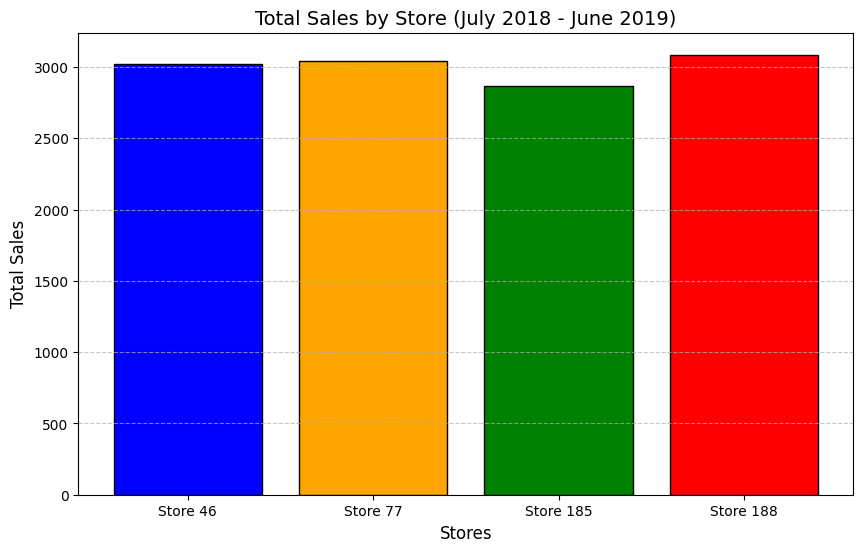

In [33]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(
    total_sales_by_store['STORE_NAME'],
    total_sales_by_store['TOT_SALES'],
    color=['blue', 'orange', 'green', 'red'],
    edgecolor='black'
)
plt.title('Total Sales by Store (July 2018 - June 2019)', fontsize=14)
plt.xlabel('Stores', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualize the total sales that the store 77 which is the trail has against those of the control stores monthly to check how each store performs per month

In [34]:
closest_stores = [77, 46, 185, 188]

In [35]:
df_2 = df

In [36]:
df_2 = df_2[df_2['STORE_NBR'].isin(closest_stores)]

In [37]:
df_2['MONTH_YEAR'] = df_2['DATE'].dt.to_period('M').astype(str)

In [38]:
# Aggregate total sales by Month-Year and Store
monthly_sales = (
    df_2.groupby(['MONTH_YEAR', 'STORE_NBR'])['TOT_SALES']
    .sum()
    .reset_index()
)

In [39]:
# Map store numbers to names
store_names = {77: "Store 77", 46: "Store 46", 185: "Store 185", 188: "Store 188"}
monthly_sales['STORE_NAME'] = monthly_sales['STORE_NBR'].map(store_names)

In [40]:
# Get unique months for looping
unique_months = monthly_sales['MONTH_YEAR'].unique()

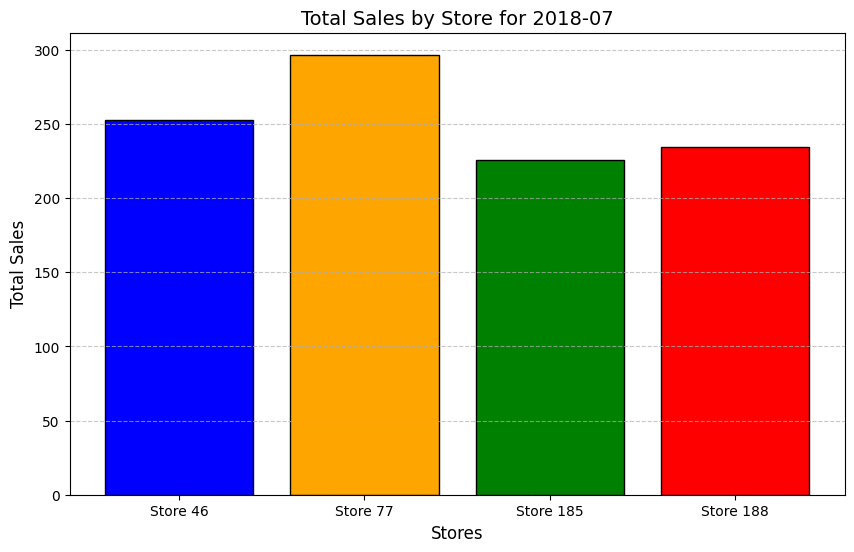

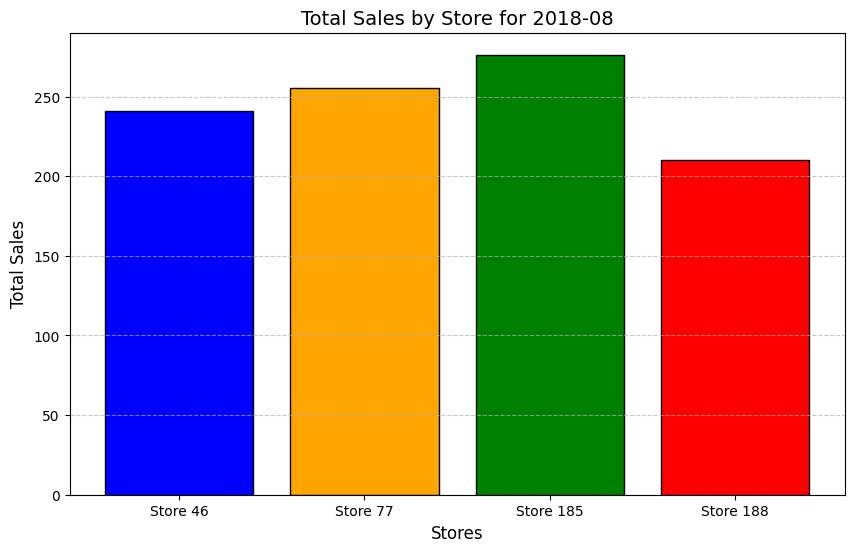

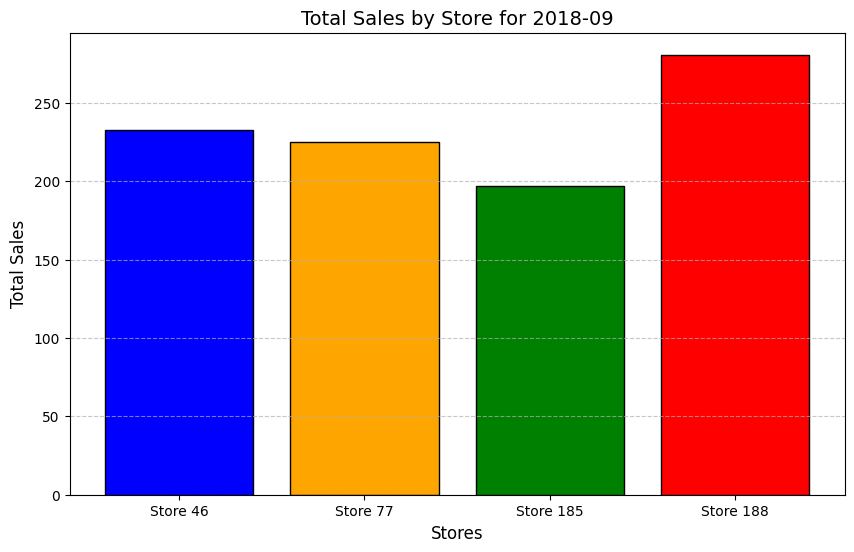

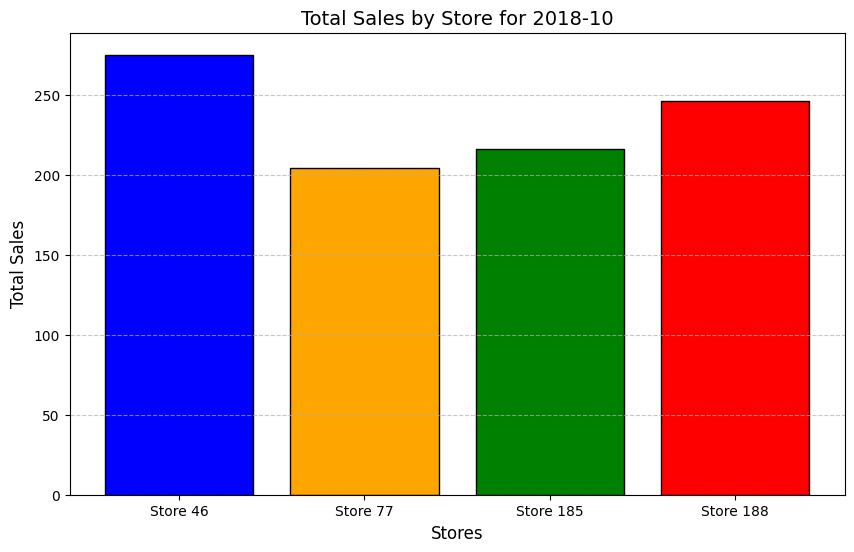

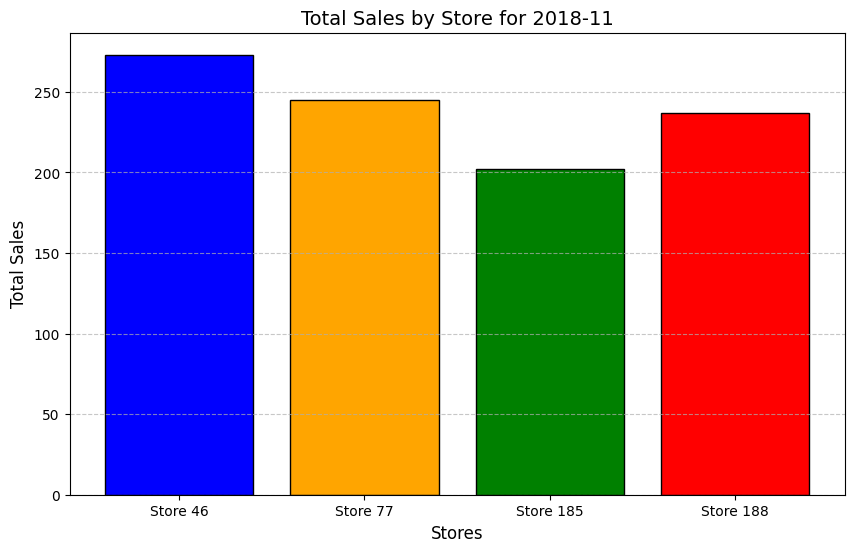

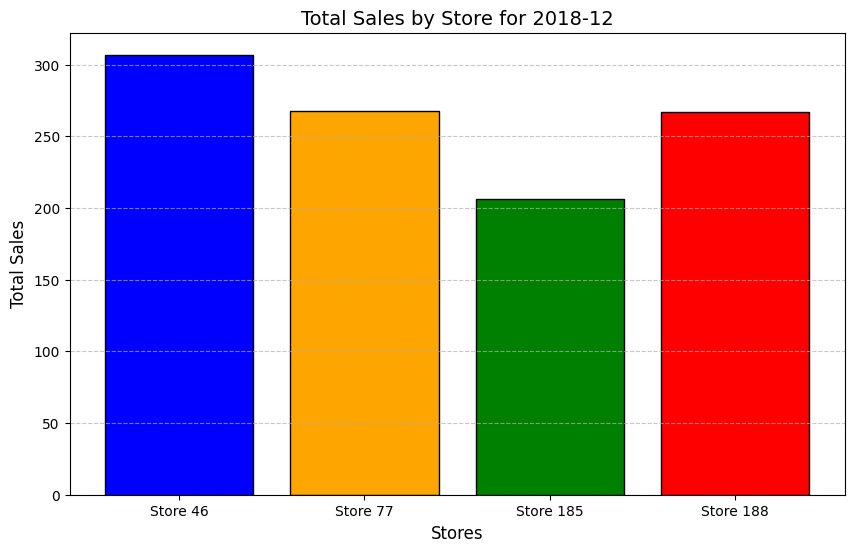

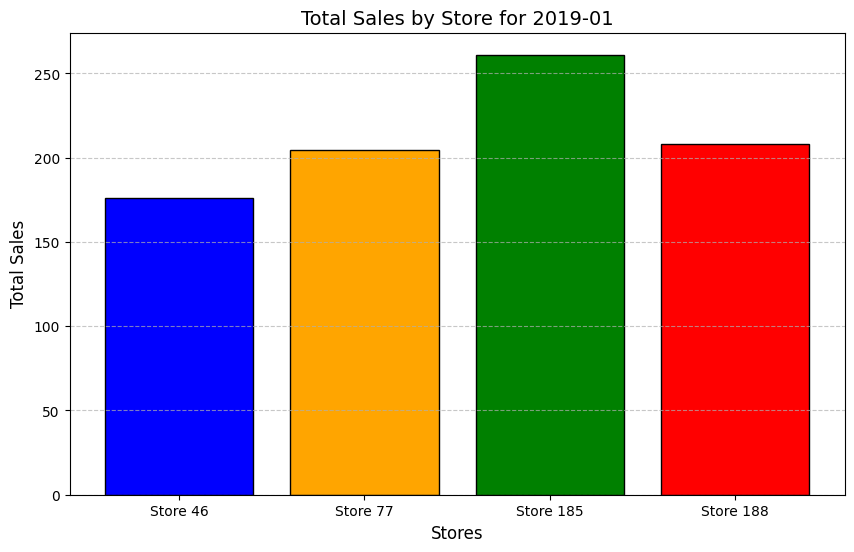

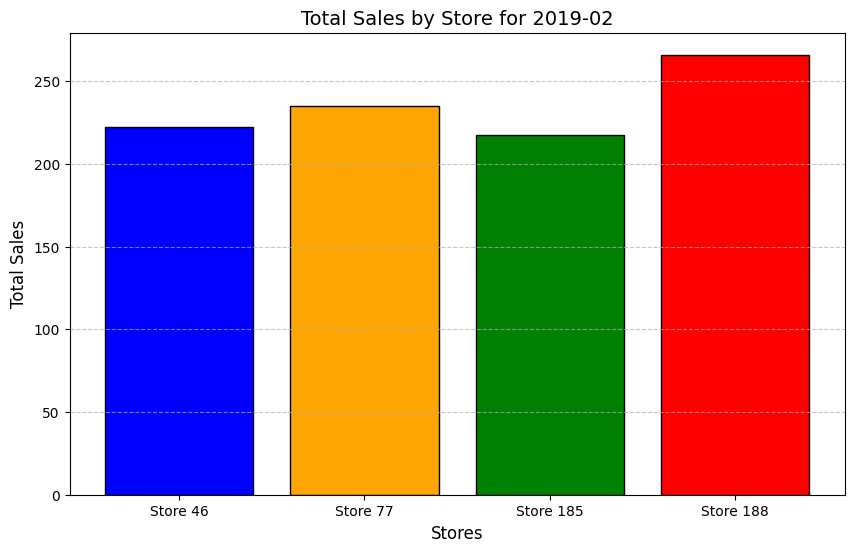

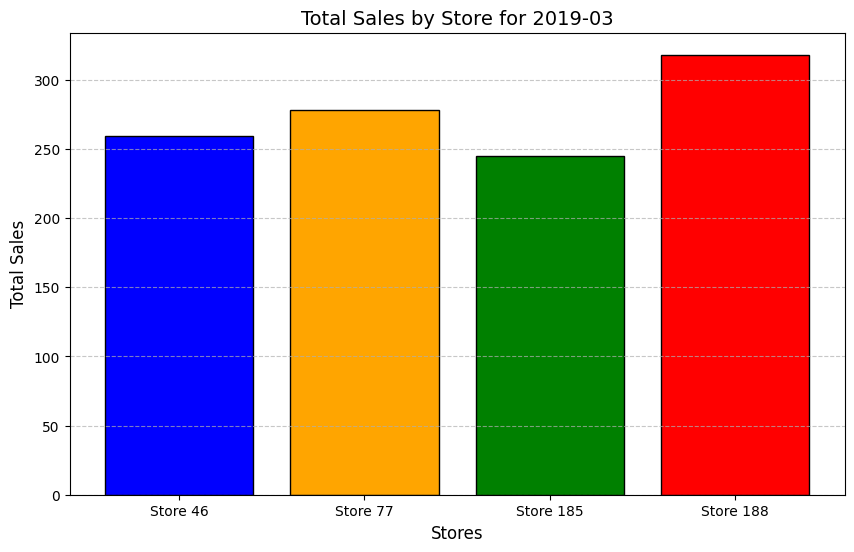

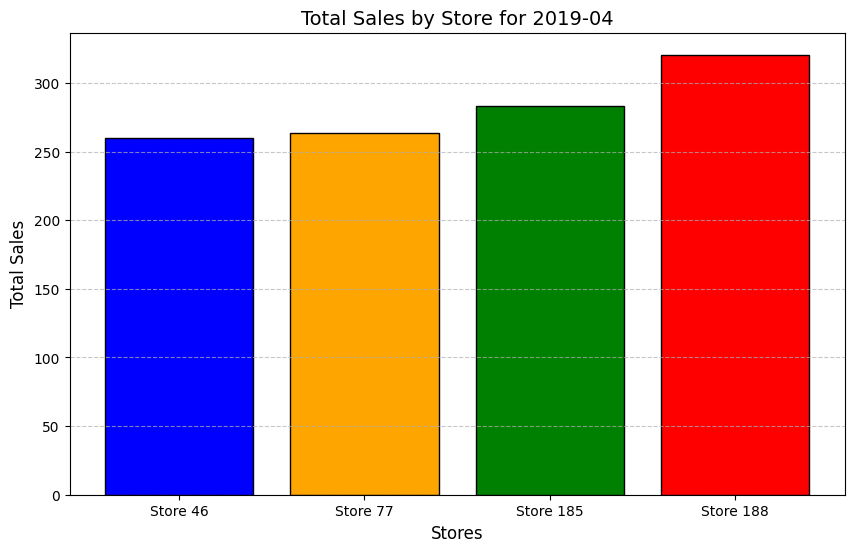

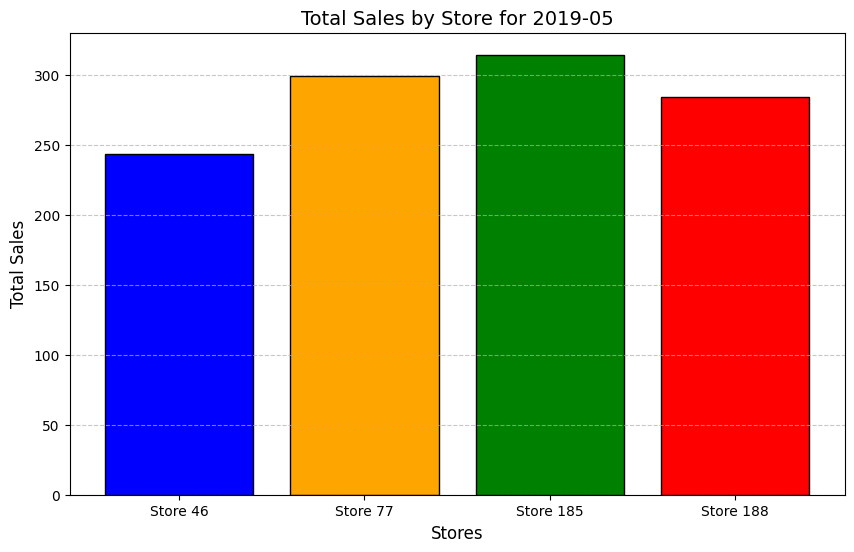

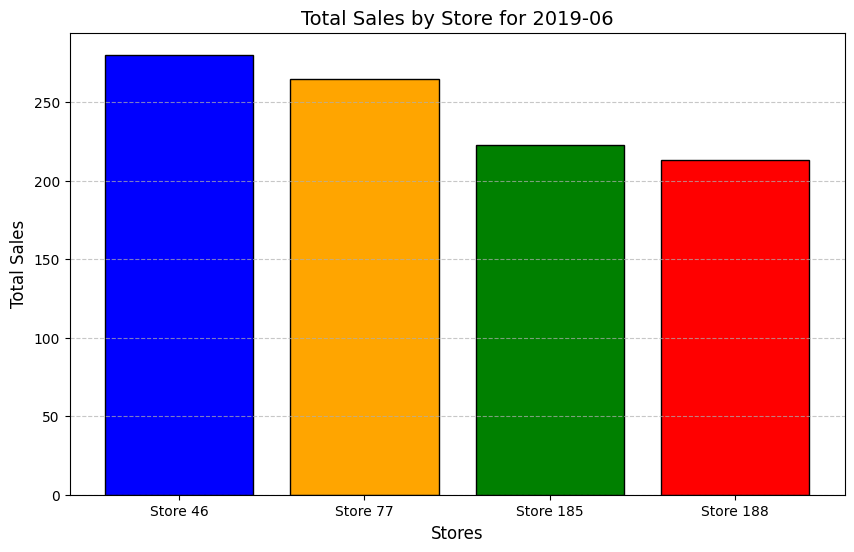

In [41]:
# Plot total sales for each month
for month in unique_months:
    monthly_data = monthly_sales[monthly_sales['MONTH_YEAR'] == month]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(
        monthly_data['STORE_NAME'],
        monthly_data['TOT_SALES'],
        color=['blue', 'orange', 'green', 'red'],
        edgecolor='black'
    )
    plt.title(f'Total Sales by Store for {month}', fontsize=14)
    plt.xlabel('Stores', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Calculate the number of customers for each store and show the visualization

In [44]:
# Count unique customers by Month-Year and Store
monthly_customers = (
    df_2.groupby(['MONTH_YEAR', 'STORE_NBR'])['LYLTY_CARD_NBR']
    .nunique()
    .reset_index()
    .rename(columns={'LYLTY_CARD_NBR': 'UNIQUE_CUSTOMERS'})
)

In [45]:
monthly_customers['STORE_NAME'] = monthly_customers['STORE_NBR'].map(store_names)

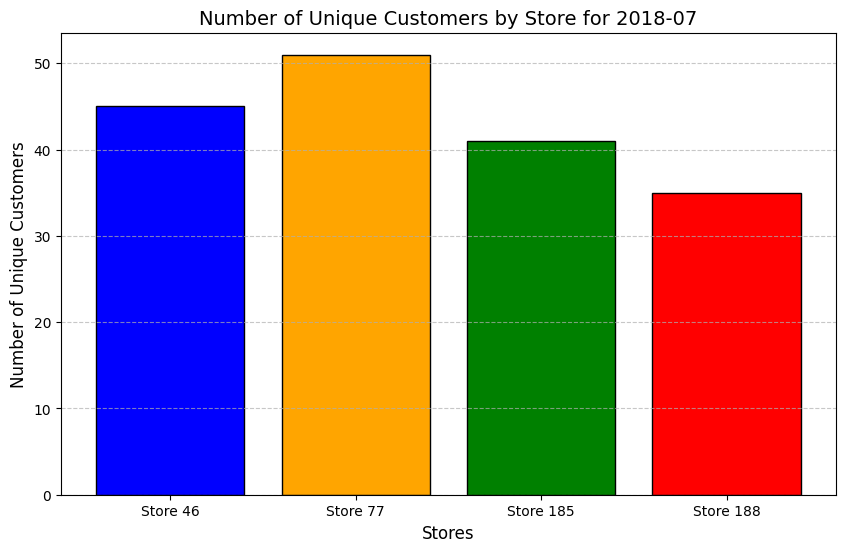

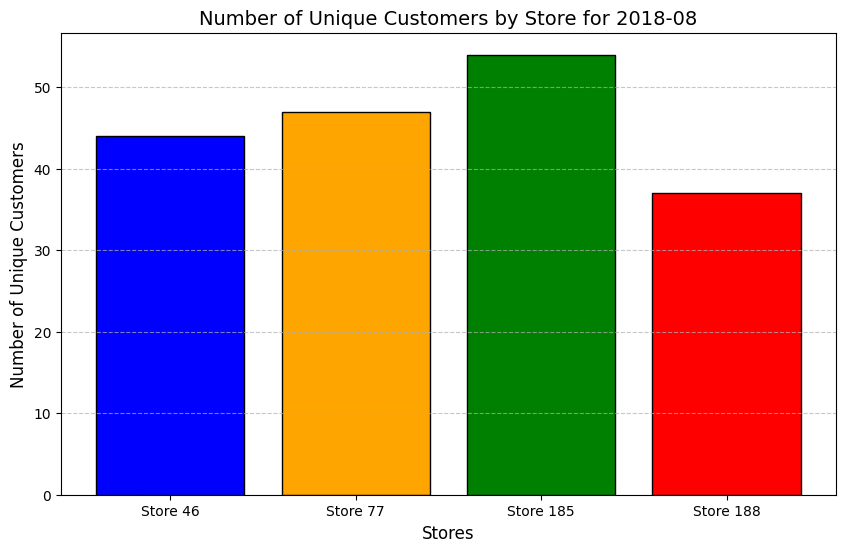

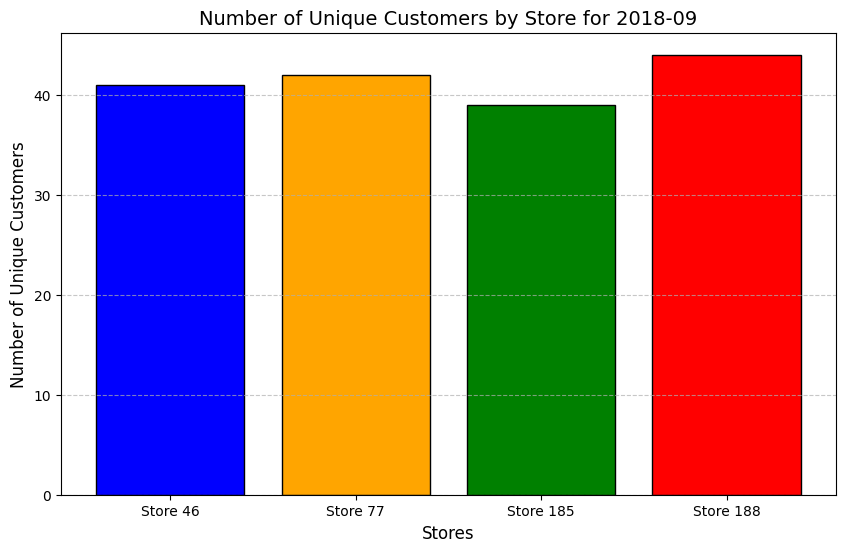

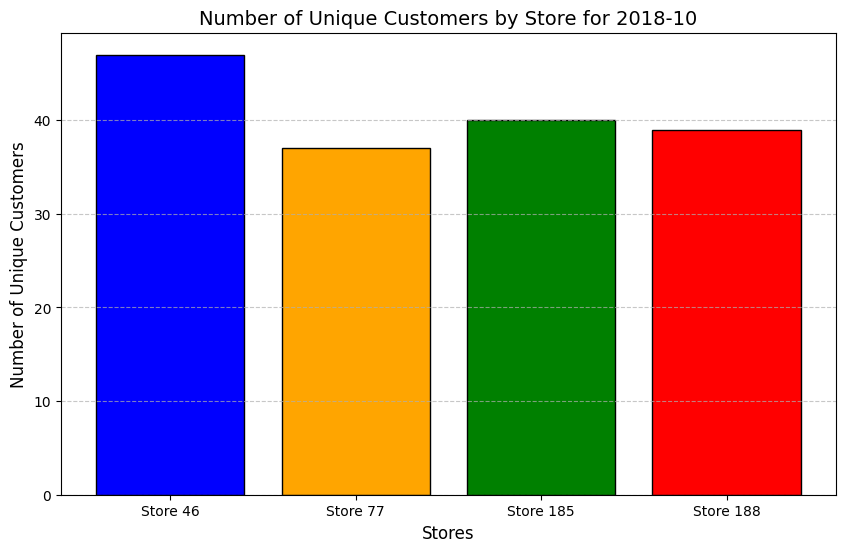

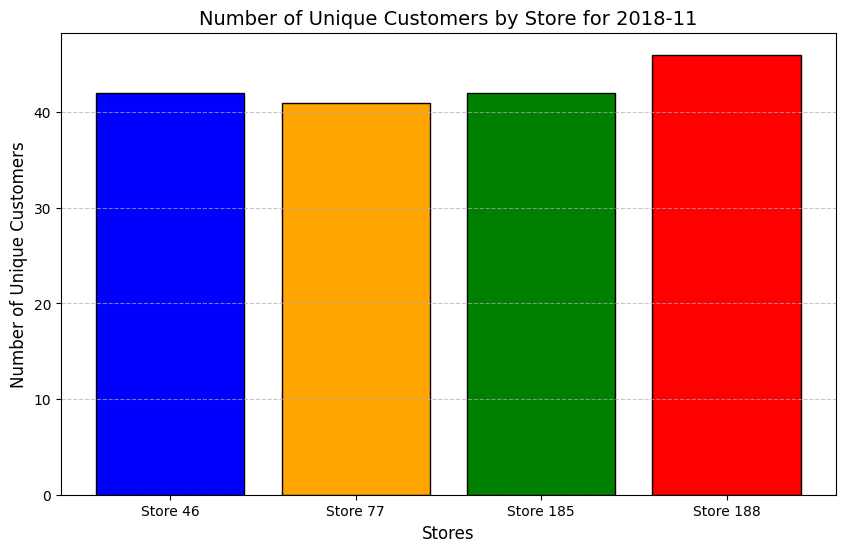

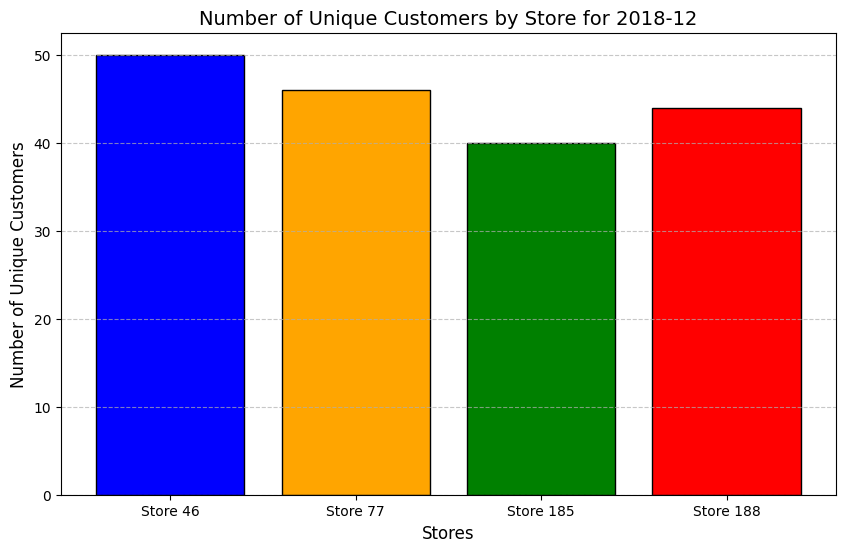

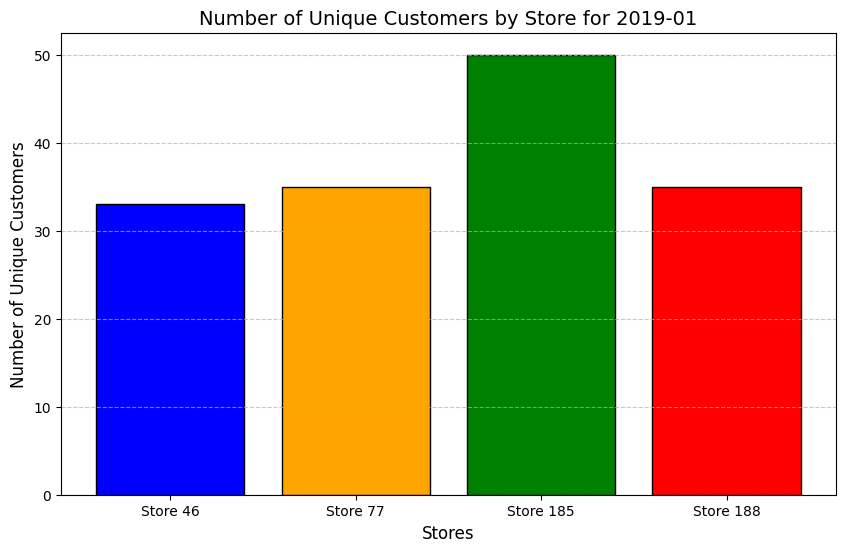

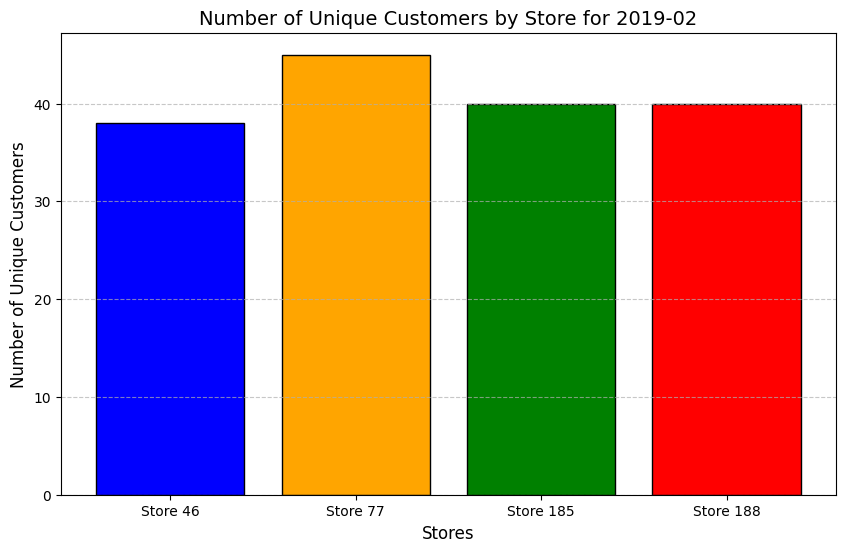

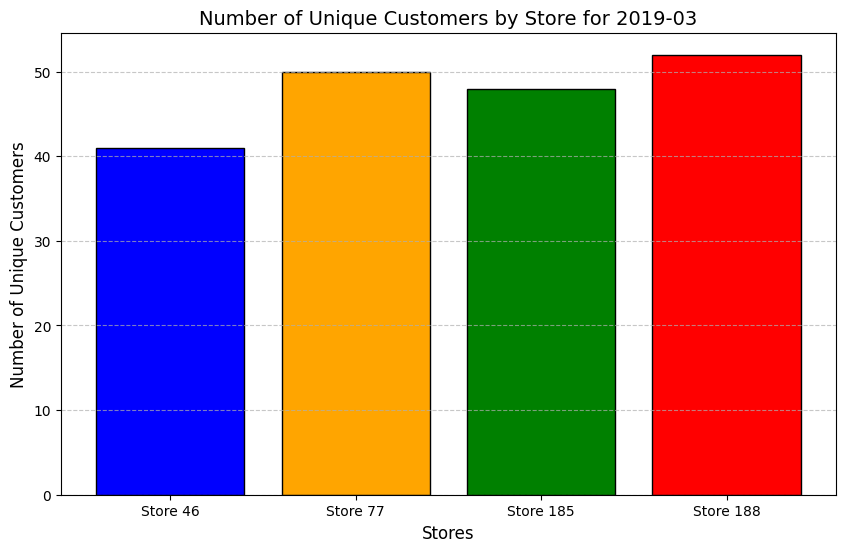

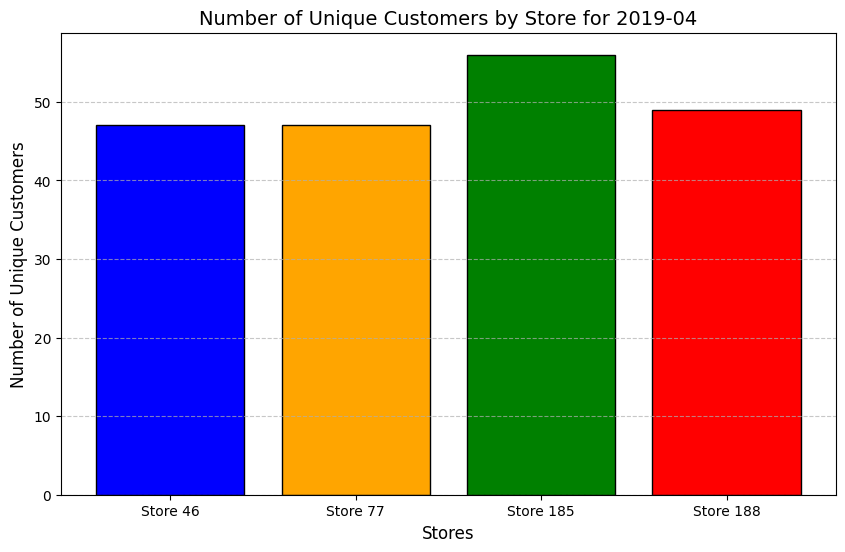

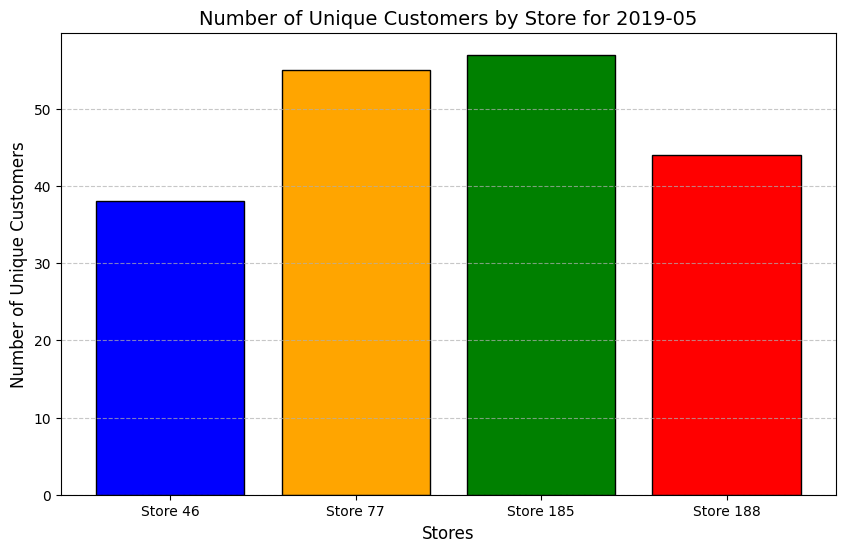

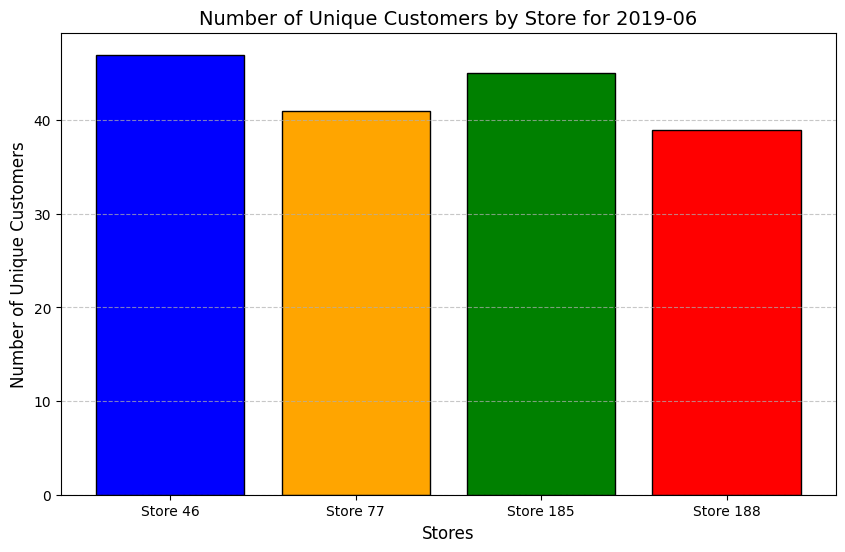

In [47]:
for month in unique_months:
    monthly_data = monthly_customers[monthly_customers['MONTH_YEAR'] == month]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(
        monthly_data['STORE_NAME'],
        monthly_data['UNIQUE_CUSTOMERS'],
        color=['blue', 'orange', 'green', 'red'],
        edgecolor='black'
    )
    plt.title(f'Number of Unique Customers by Store for {month}', fontsize=14)
    plt.xlabel('Stores', fontsize=12)
    plt.ylabel('Number of Unique Customers', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Monthly transactions 

In [49]:
# Count transactions by Month-Year and Store
monthly_transactions = (
    df_2.groupby(['MONTH_YEAR', 'STORE_NBR'])
    .size()
    .reset_index(name='TRANSACTIONS')
)

In [50]:
monthly_transactions['STORE_NAME'] = monthly_transactions['STORE_NBR'].map(store_names)

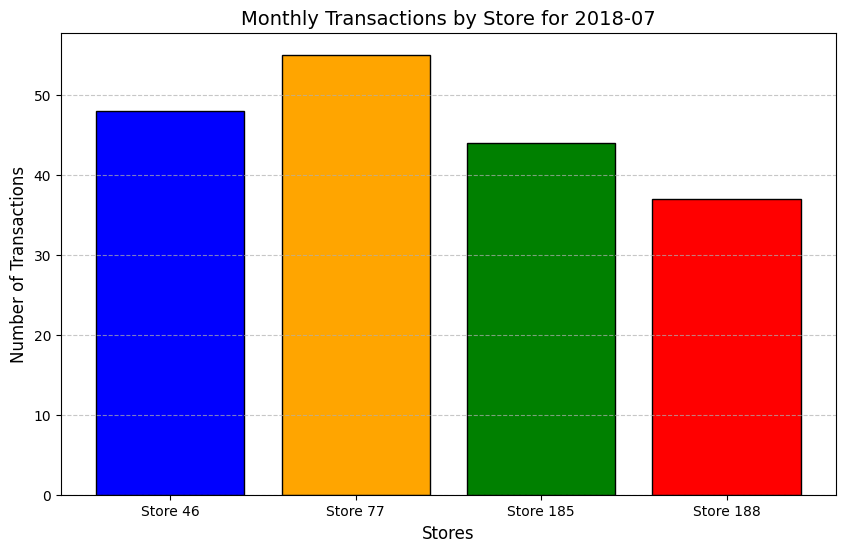

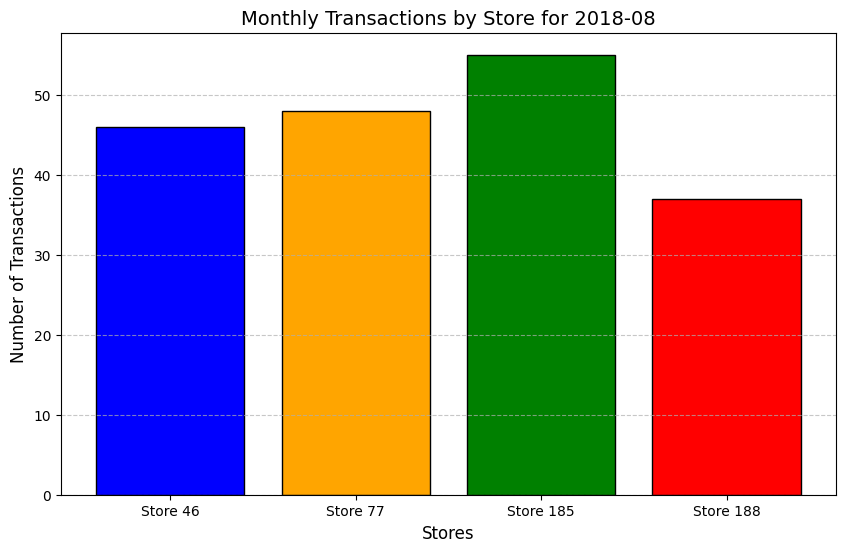

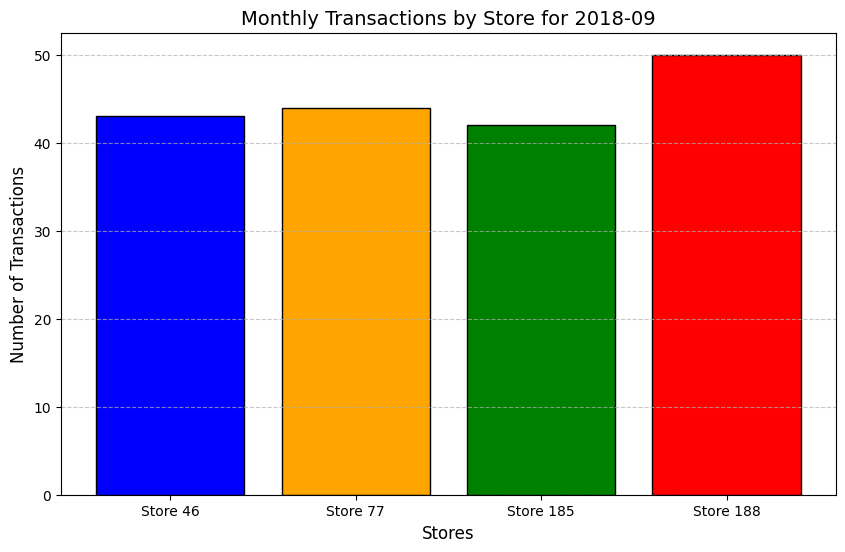

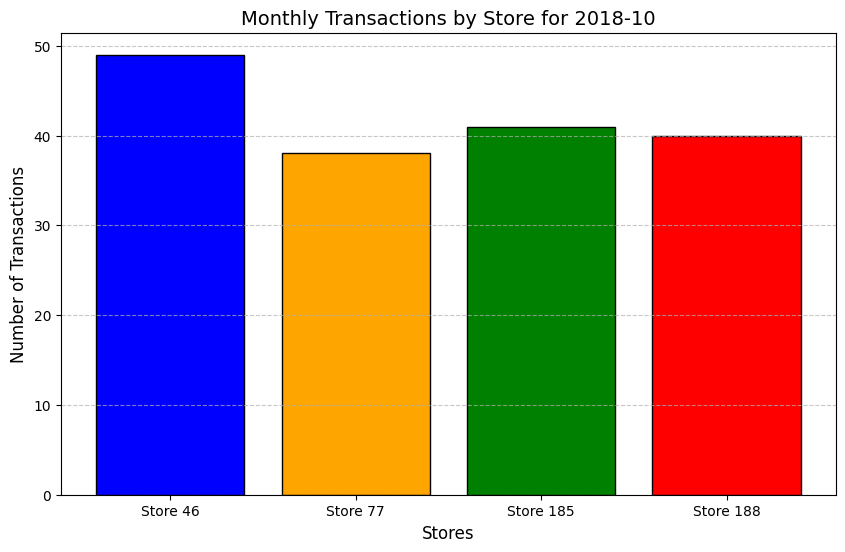

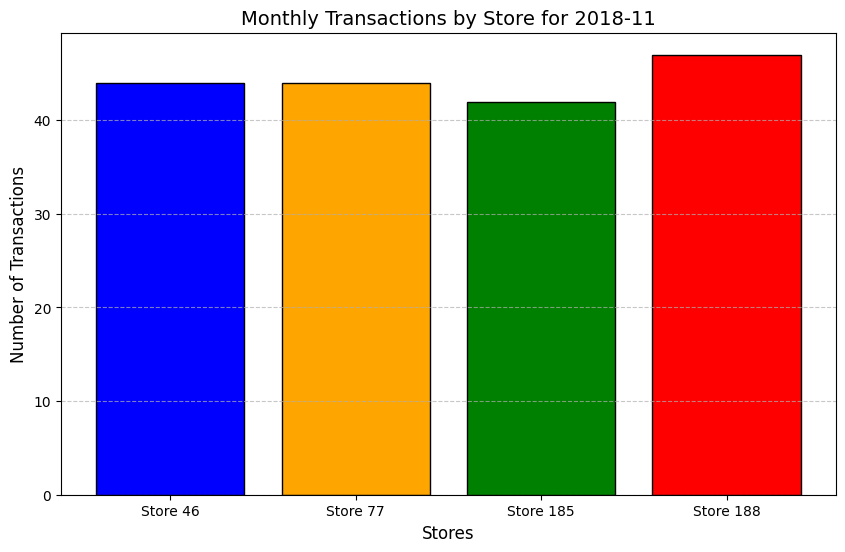

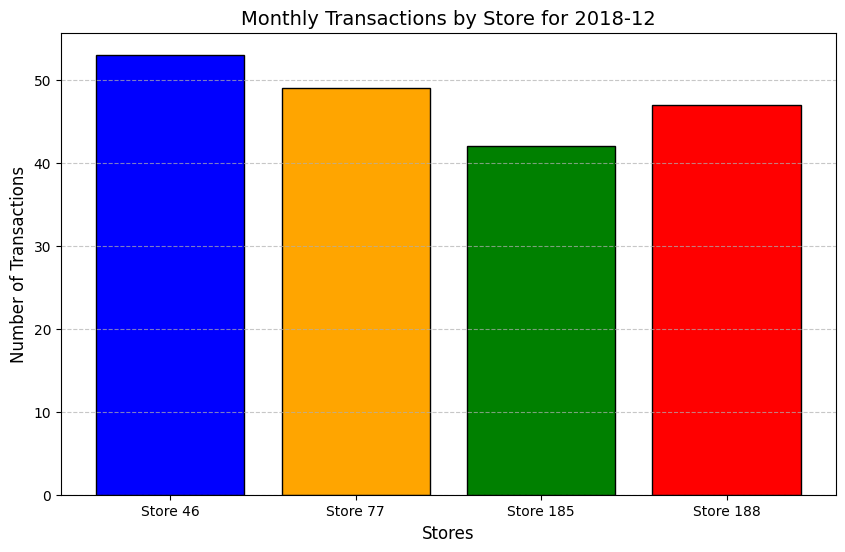

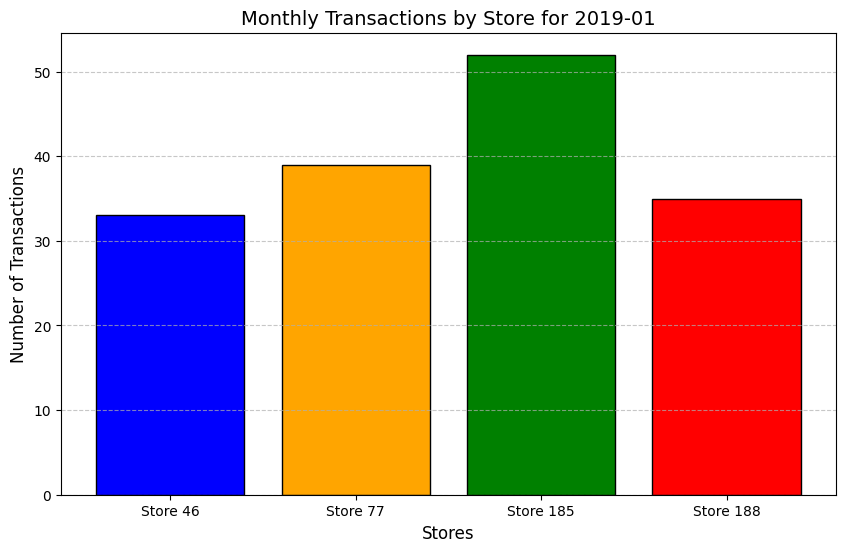

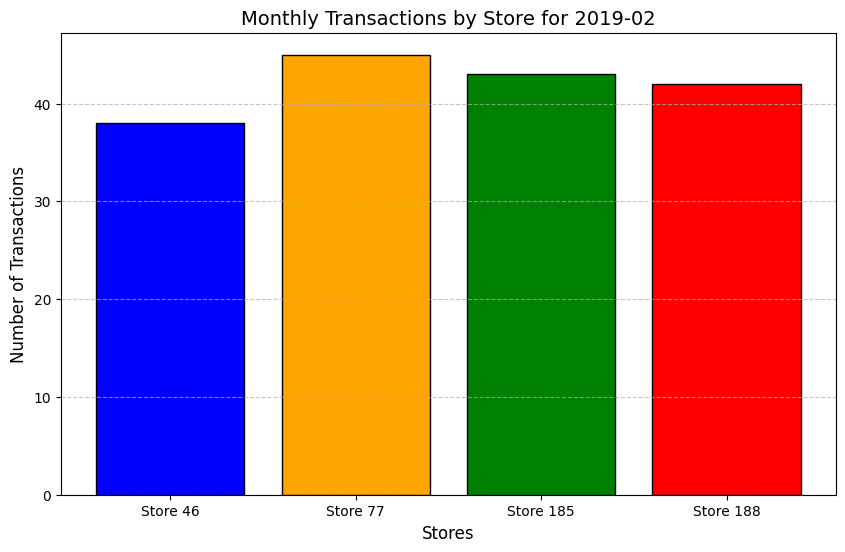

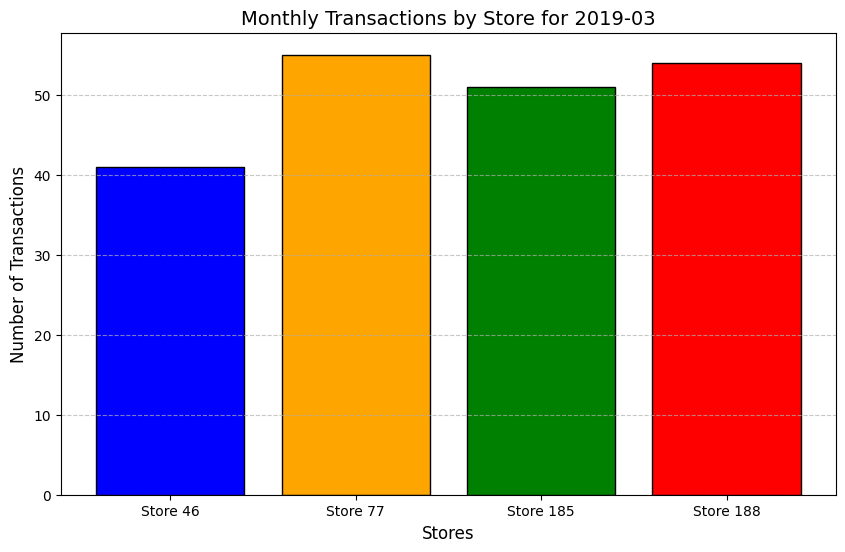

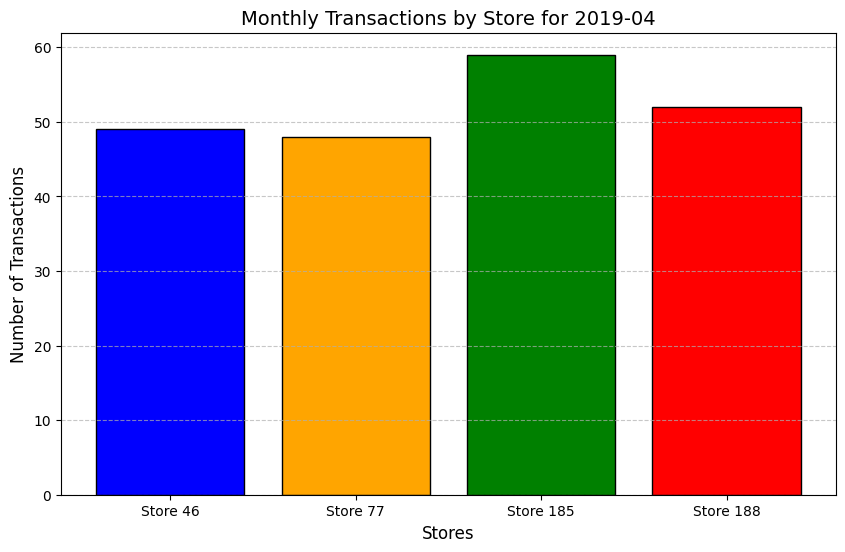

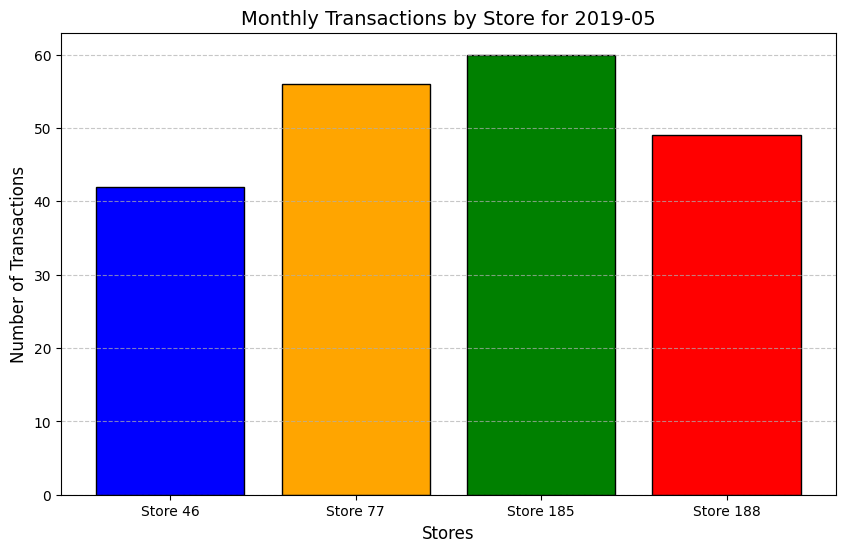

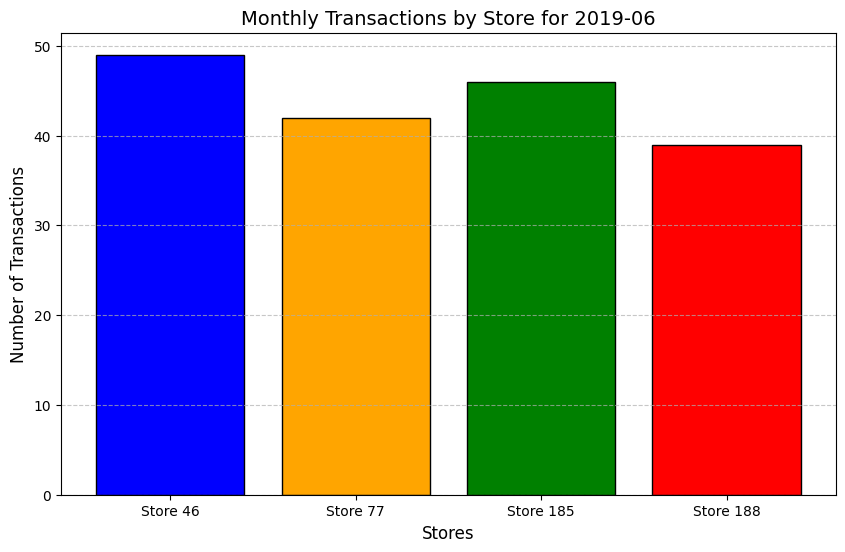

In [51]:
# Plot transactions for each month
for month in unique_months:
    monthly_data = monthly_transactions[monthly_transactions['MONTH_YEAR'] == month]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(
        monthly_data['STORE_NAME'],
        monthly_data['TRANSACTIONS'],
        color=['blue', 'orange', 'green', 'red'],
        edgecolor='black'
    )
    plt.title(f'Monthly Transactions by Store for {month}', fontsize=14)
    plt.xlabel('Stores', fontsize=12)
    plt.ylabel('Number of Transactions', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# The trial period is from February 2019 till June 2019 thus I have to perform the calculations for the store 77
1. Difference in sales against the control stores only for those months but the total difference
2. Percentage of difference against the control stores
3. For the total customers, total_Sales and number of transactions

# Difference in sales for the trial period for the shop 77

In [53]:
# Filter data for the required stores and date range (Feb 2019 to Jun 2019)
start_date = '2019-02-01'
end_date = '2019-06-30'
df_2 = df_2[(df_2['STORE_NBR'].isin(closest_store)) & 
                              (filtered_df['DATE'] >= start_date) & 
                              (filtered_df['DATE'] <= end_date)]


C:\Users\user\AppData\Local\Temp\ipykernel_15156\2963515738.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2 = df_2[(df_2['STORE_NBR'].isin(closest_store)) &


In [54]:
# Group by store and calculate the total sales
total_sales = df_2.groupby('STORE_NBR')['TOT_SALES'].sum().reset_index()

In [55]:
store_names = {77: "Store 77", 46: "Store 46", 185: "Store 185", 188: "Store 188"}
total_sales['STORE_NAME'] = total_sales['STORE_NBR'].map(store_names)

In [56]:
# Get the sales for store 77
store_77_sales = total_sales[total_sales['STORE_NBR'] == 77]['TOT_SALES'].values[0]

In [58]:
# Calculate the sales difference between store 77 and the control stores
sales_difference = {}
for store in closest_stores:
    if store != 77:
        control_store_sales = total_sales[total_sales['STORE_NBR'] == store]['TOT_SALES'].values[0]
        sales_difference[store_names[store]] = store_77_sales - control_store_sales


In [59]:
sales_difference

{'Store 46': 75.54999999999995,
 'Store 185': 56.90000000000009,
 'Store 188': -61.5}

# Interpretations

Store 46: The difference is 75.55. This means that Store 77 had 75.55 more in total sales than Store 46 during the period.

Store 185: The difference is 56.90. This means that Store 77 had 56.90 more in total sales than Store 185 during the period.

Store 188: The difference is -61.5. This means that Store 77 had 61.5 less in total sales than Store 188 during the period. A negative value indicates that Store 77 performed worse than Store 188 in terms of sales.

##### Calculate the percentage difference

In [60]:
# Calculate the percentage difference for each store
percentage_difference = {}
for store in closest_store:
    if store != 77:
        control_store_sales = total_sales[total_sales['STORE_NBR'] == store]['TOT_SALES'].values[0]
        sales_diff = sales_difference[store_names[store]]
        percentage_diff = (sales_diff / control_store_sales) * 100
        percentage_difference[store_names[store]] = percentage_diff

# Print the percentage differences
percentage_difference

{'Store 46': 5.970208226322648,
 'Store 185': 4.431119071723393,
 'Store 188': -4.385026737967915}

In [61]:
# Filter data for the required stores and date range (Feb 2019 to Jun 2019)
df_2 = df_2[(df_2['STORE_NBR'].isin(closest_stores)) & 
                              (df_2['DATE'] >= start_date) & 
                              (df_2['DATE'] <= end_date)]

# Count the number of transactions for each store
transaction_count = df_2.groupby('STORE_NBR')['TXN_ID'].nunique().reset_index(name='TRANSACTIONS')

# Map store numbers to names
transaction_count['STORE_NAME'] = transaction_count['STORE_NBR'].map(store_names)

# Get the transaction count for store 77
store_77_transactions = transaction_count[transaction_count['STORE_NBR'] == 77]['TRANSACTIONS'].values[0]

# Calculate the transaction difference between store 77 and the control stores
transaction_difference = {}
for store in closest_stores:
    if store != 77:
        control_store_transactions = transaction_count[transaction_count['STORE_NBR'] == store]['TRANSACTIONS'].values[0]
        transaction_difference[store_names[store]] = store_77_transactions - control_store_transactions

# Print the transaction differences
transaction_difference

{'Store 46': 27, 'Store 185': -13, 'Store 188': 10}

In [62]:
# Calculate the percentage difference in transactions for each store
percentage_transaction_difference = {}
for store in closest_store:
    if store != 77:
        control_store_transactions = transaction_count[transaction_count['STORE_NBR'] == store]['TRANSACTIONS'].values[0]
        transaction_diff = transaction_difference[store_names[store]]
        percentage_transaction_diff = (transaction_diff / control_store_transactions) * 100
        percentage_transaction_difference[store_names[store]] = percentage_transaction_diff

# Print the percentage differences in transactions
percentage_transaction_difference

{'Store 46': 12.32876712328767,
 'Store 185': -5.019305019305019,
 'Store 188': 4.23728813559322}